# Exercises - Fraud Detection

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import datetime
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)
plt.style.use(style = 'seaborn-v0_8')
%matplotlib inline
warnings.filterwarnings('ignore')

runCVflag = False # If False then optimal values are used

# Import Data

In [3]:
%%time
## You can retrieve the data at https://www.kaggle.com/c/ieee-fraud-detection/data 
data_path = "./"
train_tr = pd.read_csv(data_path + "train_transaction.csv")
train_id = pd.read_csv(data_path + "train_identity.csv") 
test_tr = pd.read_csv(data_path + "test_transaction.csv")
test_id = pd.read_csv(data_path + "test_identity.csv")

print('train_transaction shape is: {}'.format(train_tr.shape))
print('train_identity shape is: {}'.format(train_id.shape))

print('test_transaction shape is: {}'.format(test_tr.shape))
print('test_identity shape is: {}'.format(test_id.shape))

train_transaction shape is: (590540, 394)
train_identity shape is: (144233, 41)
test_transaction shape is: (506691, 393)
test_identity shape is: (141907, 41)
CPU times: user 10.6 s, sys: 3.53 s, total: 14.1 s
Wall time: 15.7 s


In [4]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
test_tr.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [7]:
test_id.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


## Data Preparation

In [8]:
%%time

train = pd.merge(train_tr, train_id, how = 'left', on = 'TransactionID')
test = pd.merge(test_tr, test_id, how = 'left', on = 'TransactionID')
del train_tr, train_id, test_tr, test_id
print('train set shape is: {}'.format(train.shape))
print('test set shape is: {}'.format(test.shape))

train set shape is: (590540, 434)
test set shape is: (506691, 433)
CPU times: user 1.07 s, sys: 1.7 s, total: 2.78 s
Wall time: 3.66 s


In [9]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [10]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

In [11]:
def different_columns(traincols, testcols):
    diff_cols = []
    for i in traincols:
        if i not in testcols:
            diff_cols.append(i)
    return diff_cols
            
print(different_columns(train.columns, test.columns))
# train and test sets should have the same columns (not considering the target variable 'IsFraud')

['isFraud', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [12]:
test = test.rename(columns = {"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})

print(different_columns(train.columns, test.columns))
# now test and train have the same column names

['isFraud']


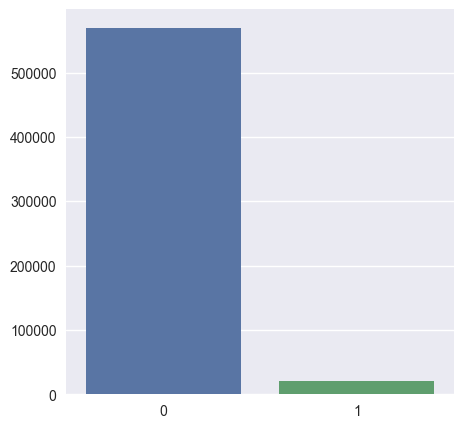

In [13]:
fig = plt.figure(figsize = (5, 5))
sns.barplot(x = [0,1], y = train['isFraud'].value_counts().values)
plt.show()

In [14]:
fraud_ratio = train['isFraud'].sum()/len(train['isFraud'])
print(fraud_ratio) # percentage of frauds in the train set
del fraud_ratio 

0.03499000914417313


In [15]:
tot_missing_value = train.isnull().sum().sum()
print(tot_missing_value) # missing values in the train set
del tot_missing_value

115523073


In [16]:
column_missing_value = train.isnull().sum()
print(column_missing_value[0 : 60])
print(column_missing_value[60 : 120])
print(column_missing_value[120 : 180])
print(column_missing_value[180 : 240])
print(column_missing_value[240 : 300])
print(column_missing_value[300 : 360])
print(column_missing_value[360 : 420])
print(column_missing_value[420 : 434])
del column_missing_value

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


Text(0.5, 1.0, 'Train vs. Test TransactionDT Distribution')

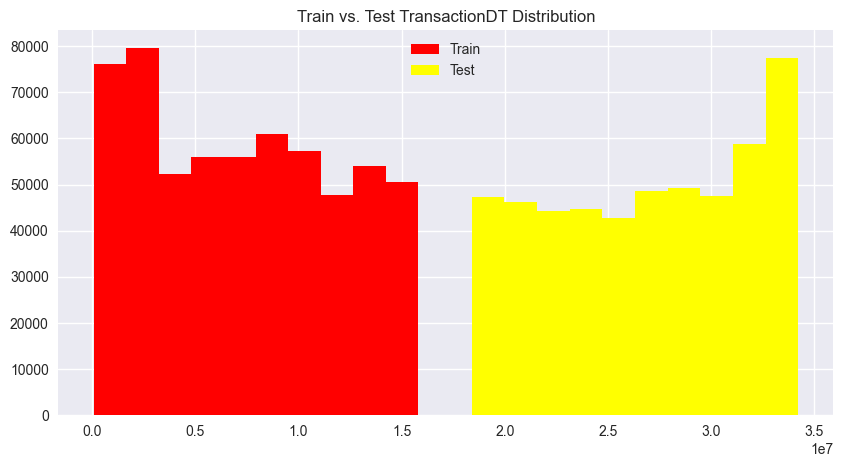

In [17]:
## PLOT TRANSACTION DATES (THEY DON'T OVERLAP) 

fig = plt.figure(figsize = (10, 5))
plt.hist(train['TransactionDT'], label = 'Train', color = 'red')
plt.hist(test['TransactionDT'], label = 'Test', color = 'yellow')
plt.legend()
plt.title('Train vs. Test TransactionDT Distribution')

## Variables Encoding

In [18]:
%%time

encoder_dict = {}

complete_labelset_temp = pd.concat([train.drop(['isFraud'], axis=1), test], axis=0).reset_index()
variables_encode = complete_labelset_temp.keys()
for k in variables_encode:
    if complete_labelset_temp[k].dtype == object:
        le = preprocessing.LabelEncoder()
        le_fit = le.fit(complete_labelset_temp[k])
        encoder_dict.update({k: le_fit})
        #train[k + '_encoded'] = le_fit.transform(train[k])  
        train[k + '_encoded'] = encoder_dict[k].transform(train[k])  
        train = train.drop([k], axis=1)
        test[k + '_encoded'] = encoder_dict[k].transform(test[k])  
        test = test.drop([k], axis=1)

del complete_labelset_temp

CPU times: user 14.4 s, sys: 27.7 s, total: 42.1 s
Wall time: 54.2 s


In [19]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,ProductCD_encoded,card4_encoded,card6_encoded,P_emaildomain_encoded,R_emaildomain_encoded,M1_encoded,M2_encoded,M3_encoded,M4_encoded,M5_encoded,M6_encoded,M7_encoded,M8_encoded,M9_encoded,id_12_encoded,id_15_encoded,id_16_encoded,id_23_encoded,id_27_encoded,id_28_encoded,id_29_encoded,id_30_encoded,id_31_encoded,id_33_encoded,id_34_encoded,id_35_encoded,id_36_encoded,id_37_encoded,id_38_encoded,DeviceType_encoded,DeviceInfo_encoded
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [20]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,ProductCD_encoded,card4_encoded,card6_encoded,P_emaildomain_encoded,R_emaildomain_encoded,M1_encoded,M2_encoded,M3_encoded,M4_encoded,M5_encoded,M6_encoded,M7_encoded,M8_encoded,M9_encoded,id_12_encoded,id_15_encoded,id_16_encoded,id_23_encoded,id_27_encoded,id_28_encoded,id_29_encoded,id_30_encoded,id_31_encoded,id_33_encoded,id_34_encoded,id_35_encoded,id_36_encoded,id_37_encoded,id_38_encoded,DeviceType_encoded,DeviceInfo_encoded
0,3663549,18403224,31.95,10409,111.0,150.0,226.0,170.0,87.0,1.0,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [21]:
print('train_set shape is: {}'.format(train.shape))
print('test_set shape is: {}'.format(test.shape))

train_set shape is: (590540, 434)
test_set shape is: (506691, 433)


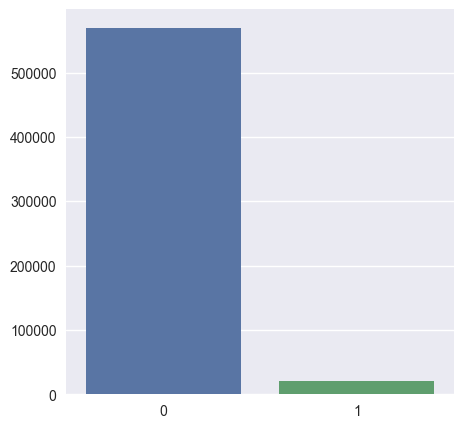

In [22]:
fig = plt.figure(figsize = (5, 5))
sns.barplot(x = [0,1], y = train['isFraud'].value_counts().values)
plt.show()

In [23]:
fraud_ratio = train['isFraud'].sum()/len(train['isFraud'])
print(fraud_ratio) # percentage of frauds in the train set
del fraud_ratio 

0.03499000914417313


In [24]:
stats_df = pd.DataFrame(columns = ['train_time', 'train_precision', 'train_accuracy', 'train_recall', 'train_roc_auc',
                                   'test_precision', 'test_accuracy', 'test_recall', 'test_roc_auc'])

In [25]:
def print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred):
    print('-----------------------------------------------------')
    print(experiment_name + ' train precision score is {}'.format(precision_score(y_train, y_train_pred)))
    print(experiment_name + ' train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
    print(experiment_name + ' train recall score is {}'.format(recall_score(y_train, y_train_pred)))
    print(experiment_name + ' train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
    print('-----------------------------------------------------')
    print(experiment_name + ' test precision score is {}'.format(precision_score(y_test, y_pred)))
    print(experiment_name + ' test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
    print(experiment_name + ' test recall score is {}'.format(recall_score(y_test, y_pred)))
    print(experiment_name + ' test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
    print('-----------------------------------------------------')
    print(' Train confusion matrix')
    print(confusion_matrix(y_train, y_train_pred))
    print('-----------------------------------------------------')
    print(' Test confusion matrix')
    print(confusion_matrix(y_test, y_pred))
    print('-----------------------------------------------------')

## Unbalanced Approach - Decision Tree

In [26]:
%%time
start_time = datetime.datetime.now()
experiment_name = 'UNBALANCED APPROACH - DECISION TREE'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

CPU times: user 3.86 s, sys: 8.01 s, total: 11.9 s
Wall time: 15.5 s


### Random Search Tuning

In [27]:
%%time

if runCVflag:
    clf_model = DecisionTreeClassifier(criterion="gini")
    distrib = dict(max_depth = [10,100,500], min_samples_leaf=[5,10,20,50])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_min_samples_leaf = search.best_params_['min_samples_leaf']
    best_max_depth = search.best_params_['max_depth']
else:
    # results ====> optimal values are: 'min_samples_leaf': 20, 'max_depth': 10
    best_min_samples_leaf = 20
    best_max_depth = 10

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


### Training

In [28]:
%%time
clf_model = DecisionTreeClassifier(criterion="gini", max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf)
clf_model.fit(X_train_imp,y_train)
end_time = datetime.datetime.now() - start_time

CPU times: user 13.2 s, sys: 511 ms, total: 13.7 s
Wall time: 14 s


### Predict

In [29]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)

stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
UNBALANCED APPROACH - DECISION TREE train precision score is 0.8881843489019486
UNBALANCED APPROACH - DECISION TREE train accuracy score is 0.975490652623023
UNBALANCED APPROACH - DECISION TREE train recall score is 0.3459846978733659
UNBALANCED APPROACH - DECISION TREE train auc score is 0.6721992953403
-----------------------------------------------------
UNBALANCED APPROACH - DECISION TREE test precision score is 0.6646115906288532
UNBALANCED APPROACH - DECISION TREE test accuracy score is 0.9701121007891083
UNBALANCED APPROACH - DECISION TREE test recall score is 0.265255905511811
UNBALANCED APPROACH - DECISION TREE test auc score is 0.6302429083870655
-----------------------------------------------------
 Train confusion matrix
[[455110    723]
 [ 10856   5743]]
-----------------------------------------------------
 Test confusion matrix
[[113500    544]
 [  2986   1078]]
-----------------------------------------------------
CP

## Unbalanced Approach - Xgboost

In [30]:
%%time
start_time = datetime.datetime.now()
experiment_name = 'UNBALANCED APPROACH - XGBOOST'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

CPU times: user 3.24 s, sys: 5.77 s, total: 9.01 s
Wall time: 11.9 s


### Random Search Tuning

In [31]:
%%time

if runCVflag:
    clf_model = xgb.XGBClassifier()
    distrib = dict(max_depth = [5,10], n_estimators = [50, 100], learning_rate=[0.02, 0.1, 0.2])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_n_estimators = search.best_params_['n_estimators']
    best_max_depth = search.best_params_['max_depth']
    best_learning_rate = search.best_params_['learning_rate']
else:
    # results ====> optimal values are: 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.02
    best_max_depth = 10
    best_n_estimators = 100
    best_learning_rate = 0.02

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


### Training

In [32]:
%%time
xgmodel = xgb.XGBClassifier(max_depth = best_max_depth,
                            n_estimators = best_n_estimators,
                            learning_rate = best_learning_rate)

xgmodel.fit(X_train_imp,y_train)

end_time = datetime.datetime.now() - start_time

CPU times: user 21min 50s, sys: 6min 52s, total: 28min 43s
Wall time: 6min 20s


### Predict

In [33]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)


stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
UNBALANCED APPROACH - XGBOOST train precision score is 0.9789613848202396
UNBALANCED APPROACH - XGBOOST train accuracy score is 0.9800923730822637
UNBALANCED APPROACH - XGBOOST train recall score is 0.4429182480872342
UNBALANCED APPROACH - XGBOOST train auc score is 0.7212858149589304
-----------------------------------------------------
UNBALANCED APPROACH - XGBOOST test precision score is 0.8119079837618404
UNBALANCED APPROACH - XGBOOST test accuracy score is 0.9733972296542148
UNBALANCED APPROACH - XGBOOST test recall score is 0.2952755905511811
UNBALANCED APPROACH - XGBOOST test auc score is 0.6464189674547494
-----------------------------------------------------
 Train confusion matrix
[[455675    158]
 [  9247   7352]]
-----------------------------------------------------
 Test confusion matrix
[[113766    278]
 [  2864   1200]]
-----------------------------------------------------
CPU times: user 6.41 s, sys: 1.29 s, total: 7

## Undersampling Approach - Decision Tree

In [34]:
%%time
start_time = datetime.datetime.now()

experiment_name = 'UNDERSAMPLING APPROACH - DECISION TREE'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Undersample the train dataset
ros = RandomUnderSampler(random_state=17)

X_train_imp, y_train = ros.fit_resample(X_train_imp, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train)))

Resampled dataset shape Counter({0: 16599, 1: 16599})
CPU times: user 3.37 s, sys: 6.3 s, total: 9.68 s
Wall time: 13.3 s


### Random Search Tuning

In [35]:
%%time

if runCVflag:
    clf_model = DecisionTreeClassifier(criterion="gini")
    distrib = dict(max_depth = [10,100,500], min_samples_leaf=[5,10,20,50])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_min_samples_leaf = search.best_params_['min_samples_leaf']
    best_max_depth = search.best_params_['max_depth']
else:
    # results ====> optimal values are: 'min_samples_leaf': 50, 'max_depth': 10
    best_min_samples_leaf = 50
    best_max_depth = 10

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


### Training

In [36]:
%%time
clf_model = DecisionTreeClassifier(criterion="gini", 
                                   max_depth = best_max_depth, 
                                   min_samples_leaf = best_min_samples_leaf)

clf_model.fit(X_train_imp,y_train)

end_time = datetime.datetime.now() - start_time

CPU times: user 1.01 s, sys: 8.11 ms, total: 1.02 s
Wall time: 1.02 s


### Predict

In [37]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)



stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
UNDERSAMPLING APPROACH - DECISION TREE train precision score is 0.8056066740277267
UNDERSAMPLING APPROACH - DECISION TREE train accuracy score is 0.8001385625640098
UNDERSAMPLING APPROACH - DECISION TREE train recall score is 0.7911922404964155
UNDERSAMPLING APPROACH - DECISION TREE train auc score is 0.8001385625640098
-----------------------------------------------------
UNDERSAMPLING APPROACH - DECISION TREE test precision score is 0.11404153292857419
UNDERSAMPLING APPROACH - DECISION TREE test accuracy score is 0.7965844819995258
UNDERSAMPLING APPROACH - DECISION TREE test recall score is 0.7256397637795275
UNDERSAMPLING APPROACH - DECISION TREE test auc score is 0.7623761934887957
-----------------------------------------------------
 Train confusion matrix
[[13430  3169]
 [ 3466 13133]]
-----------------------------------------------------
 Test confusion matrix
[[91134 22910]
 [ 1115  2949]]
----------------------------------

## Undersampling Approach - Xgboost

In [38]:
%%time
start_time = datetime.datetime.now()

experiment_name = 'UNDERSAMPLING APPROACH - XGBOOST'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Undersample the train dataset
ros = RandomUnderSampler(random_state=17)

X_train_imp, y_train = ros.fit_resample(X_train_imp, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train)))

Resampled dataset shape Counter({0: 16599, 1: 16599})
CPU times: user 3.42 s, sys: 6.41 s, total: 9.83 s
Wall time: 12.5 s


### Random Search Tuning

In [39]:
%%time

if runCVflag:
    clf_model = xgb.XGBClassifier()
    distrib = dict(max_depth = [5,10], n_estimators = [50, 100], learning_rate=[0.02, 0.1, 0.2])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_n_estimators = search.best_params_['n_estimators']
    best_max_depth = search.best_params_['max_depth']
    best_learning_rate = search.best_params_['learning_rate']
else:
    # results ====> optimal values are: 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.02
    best_max_depth = 50
    best_n_estimators = 5
    best_learning_rate = 0.02

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


### Training

In [40]:
%%time
xgmodel = xgb.XGBClassifier(max_depth = best_max_depth,
                            n_estimators = best_n_estimators,
                            learning_rate = best_learning_rate)

xgmodel.fit(X_train_imp,y_train)

end_time = datetime.datetime.now() - start_time

CPU times: user 14.5 s, sys: 749 ms, total: 15.3 s
Wall time: 2.15 s


### Predict

In [41]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)


stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
UNDERSAMPLING APPROACH - XGBOOST train precision score is 0.9579144551982517
UNDERSAMPLING APPROACH - XGBOOST train accuracy score is 0.9418037231158504
UNDERSAMPLING APPROACH - XGBOOST train recall score is 0.9242123019459003
UNDERSAMPLING APPROACH - XGBOOST train auc score is 0.9418037231158503
-----------------------------------------------------
UNDERSAMPLING APPROACH - XGBOOST test precision score is 0.12320854686007122
UNDERSAMPLING APPROACH - XGBOOST test accuracy score is 0.8186744335692756
UNDERSAMPLING APPROACH - XGBOOST test recall score is 0.6980807086614174
UNDERSAMPLING APPROACH - XGBOOST test auc score is 0.7605262720466779
-----------------------------------------------------
 Train confusion matrix
[[15925   674]
 [ 1258 15341]]
-----------------------------------------------------
 Test confusion matrix
[[93855 20189]
 [ 1227  2837]]
-----------------------------------------------------
CPU times: user 2.66 s, sys:

## Oversampling Approach - Decision Tree

In [42]:
%%time
start_time = datetime.datetime.now()

experiment_name = 'OVERSAMPLING APPROACH - DECISION TREE'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Undersample the train dataset
ros = RandomOverSampler(random_state=17)

X_train_imp, y_train = ros.fit_resample(X_train_imp, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train)))

Resampled dataset shape Counter({0: 455833, 1: 455833})
CPU times: user 4.95 s, sys: 8.85 s, total: 13.8 s
Wall time: 17.2 s


### Random Search Tuning

In [43]:
%%time

if runCVflag:
    clf_model = DecisionTreeClassifier(criterion="gini")
    distrib = dict(max_depth = [10,100,500], min_samples_leaf=[5,10,20,50])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_min_samples_leaf = search.best_params_['min_samples_leaf']
    best_max_depth = search.best_params_['max_depth']
else:
    # results ====> optimal values are: 'min_samples_leaf': 5, 'max_depth': 100
    best_min_samples_leaf = 5
    best_max_depth = 100

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


### Training

In [44]:
%%time
clf_model = DecisionTreeClassifier(criterion="gini", 
                                   max_depth = best_max_depth, 
                                   min_samples_leaf = best_min_samples_leaf)

clf_model.fit(X_train_imp,y_train)

end_time = datetime.datetime.now() - start_time

CPU times: user 1min 11s, sys: 1.48 s, total: 1min 13s
Wall time: 1min 13s


### Predict

In [45]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)


stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
OVERSAMPLING APPROACH - DECISION TREE train precision score is 0.9907560760379581
OVERSAMPLING APPROACH - DECISION TREE train accuracy score is 0.9953349143216924
OVERSAMPLING APPROACH - DECISION TREE train recall score is 1.0
OVERSAMPLING APPROACH - DECISION TREE train auc score is 0.9953349143216923
-----------------------------------------------------
OVERSAMPLING APPROACH - DECISION TREE test precision score is 0.2865407520843968
OVERSAMPLING APPROACH - DECISION TREE test accuracy score is 0.9443475463135436
OVERSAMPLING APPROACH - DECISION TREE test recall score is 0.41437007874015747
OVERSAMPLING APPROACH - DECISION TREE test auc score is 0.6888017837845153
-----------------------------------------------------
 Train confusion matrix
[[451580   4253]
 [     0 455833]]
-----------------------------------------------------
 Test confusion matrix
[[109851   4193]
 [  2380   1684]]
-------------------------------------------------

## Oversampling Approach - Xgboost

In [46]:
%%time
start_time = datetime.datetime.now()

experiment_name = 'OVERSAMPLING APPROACH - XGBOOST'

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=False)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Undersample the train dataset
ros = RandomOverSampler(random_state=17)

X_train_imp, y_train = ros.fit_resample(X_train_imp, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train)))

Resampled dataset shape Counter({0: 455833, 1: 455833})
CPU times: user 4.41 s, sys: 7.18 s, total: 11.6 s
Wall time: 15.6 s


### Random Search Tuning

In [47]:
%%time

if runCVflag:
    clf_model = xgb.XGBClassifier()
    distrib = dict(max_depth = [5,10], n_estimators = [50, 100], learning_rate=[0.02, 0.1, 0.2])
    clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
    search = clf.fit(X_train_imp,y_train)
    best_n_estimators = search.best_params_['n_estimators']
    best_max_depth = search.best_params_['max_depth']
    best_learning_rate = search.best_params_['learning_rate']
else:
    # results ====> optimal values are: 'n_estimators': 5, 'max_depth': 50, 'learning_rate': 0.02
    best_max_depth = 5
    best_n_estimators = 50
    best_learning_rate = 0.02

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


### Training

In [48]:
%%time
xgmodel = xgb.XGBClassifier(max_depth = best_max_depth,
                            n_estimators = best_n_estimators,
                            learning_rate = best_learning_rate)

xgmodel.fit(X_train_imp,y_train)

end_time = datetime.datetime.now() - start_time

CPU times: user 11min 2s, sys: 6min 57s, total: 18min
Wall time: 4min 42s


### Predict

In [49]:
%%time
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)


stats_df.loc[experiment_name] = ([end_time,
                                  precision_score(y_train, y_train_pred),
                                  accuracy_score(y_train, y_train_pred),
                                  recall_score(y_train, y_train_pred),
                                  roc_auc_score(y_train, y_train_pred),
                                  precision_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  recall_score(y_test, y_pred),
                                  roc_auc_score(y_test, y_pred),
                                 ])

print_metric_stats(experiment_name, y_train, y_train_pred, y_test, y_pred)

-----------------------------------------------------
OVERSAMPLING APPROACH - XGBOOST train precision score is 0.8301423407530396
OVERSAMPLING APPROACH - XGBOOST train accuracy score is 0.7931325726746418
OVERSAMPLING APPROACH - XGBOOST train recall score is 0.7370813433867228
OVERSAMPLING APPROACH - XGBOOST train auc score is 0.7931325726746419
-----------------------------------------------------
OVERSAMPLING APPROACH - XGBOOST test precision score is 0.13964787377333077
OVERSAMPLING APPROACH - XGBOOST test accuracy score is 0.8387408134927354
OVERSAMPLING APPROACH - XGBOOST test recall score is 0.7143208661417323
OVERSAMPLING APPROACH - XGBOOST test auc score is 0.7787477151725112
-----------------------------------------------------
 Train confusion matrix
[[387086  68747]
 [119847 335986]]
-----------------------------------------------------
 Test confusion matrix
[[96159 17885]
 [ 1161  2903]]
-----------------------------------------------------
CPU times: user 6.21 s, sys: 2.3

## Results

In [50]:
display(stats_df)

,train_time,train_precision,train_accuracy,train_recall,train_roc_auc,test_precision,test_accuracy,test_recall,test_roc_auc
UNBALANCED APPROACH - DECISION TREE,0 days 00:00:29.432957,0.888184,0.975491,0.345985,0.672199,0.664612,0.970112,0.265256,0.630243
UNBALANCED APPROACH - XGBOOST,0 days 00:06:32.207387,0.978961,0.980092,0.442918,0.721286,0.811908,0.973397,0.295276,0.646419
UNDERSAMPLING APPROACH - DECISION TREE,0 days 00:00:14.338556,0.805607,0.800139,0.791192,0.800139,0.114042,0.796584,0.725640,0.762376
UNDERSAMPLING APPROACH - XGBOOST,0 days 00:00:14.699162,0.957914,0.941804,0.924212,0.941804,0.123209,0.818674,0.698081,0.760526
OVERSAMPLING APPROACH - DECISION TREE,0 days 00:01:31.023097,0.990756,0.995335,1.000000,0.995335,0.286541,0.944348,0.414370,0.688802
OVERSAMPLING APPROACH - XGBOOST,0 days 00:04:57.792208,0.830142,0.793133,0.737081,0.793133,0.139648,0.838741,0.714321,0.778748
